<a href="https://colab.research.google.com/github/SuRak35/Causal_Inference__ISI-Kolkata/blob/main/Customer_loyalty.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install dowhy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.4/383.4 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.5/174.5 kB 10.8 MB/s eta 0:00:00


In [ ]:
# Creating some simulated data for our example
import pandas as pd
import numpy as np
num_users = 10000
num_months = 12

signup_months = np.random.choice(np.arange(1, num_months), num_users) * np.random.randint(0,2, size=num_users) # signup_months == 0 means customer did not sign up
df = pd.DataFrame({
    'user_id': np.repeat(np.arange(num_users), num_months),
    'signup_month': np.repeat(signup_months, num_months), # signup month == 0 means customer did not sign up
    'month': np.tile(np.arange(1, num_months+1), num_users), # months are from 1 to 12
    'spend': np.random.poisson(500, num_users*num_months) #np.random.beta(a=2, b=5, size=num_users * num_months)*1000 # centered at 500
})
# A customer is in the treatment group if and only if they signed up
df["treatment"] = df["signup_month"]>0
# Simulating an effect of month (monotonically decreasing--customers buy less later in the year)
df["spend"] = df["spend"] - df["month"]*10
# Simulating a simple treatment effect of 100
after_signup = (df["signup_month"] < df["month"]) & (df["treatment"])
df.loc[after_signup,"spend"] = df[after_signup]["spend"] + 100
df

,user_id,signup_month,month,spend,treatment
0,0,11,1,492,True
1,0,11,2,474,True
2,0,11,3,518,True
3,0,11,4,488,True
4,0,11,5,430,True
...,...,...,...,...,...
119995,9999,8,8,441,True
119996,9999,8,9,532,True
119997,9999,8,10,543,True
119998,9999,8,11,483,True


In [ ]:
import dowhy

# Setting the signup month (for ease of analysis)
i = 3

<ipython-input-6-06610cbec150>:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(
ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...


      user_id  signup_month  treatment  pre_spends  post_spends
0           3             0      False       492.5   425.111111
1           4             0      False       502.5   408.222222
2           5             0      False       453.0   423.333333
3           6             0      False       470.5   418.222222
4           9             0      False       495.5   425.000000
...       ...           ...        ...         ...          ...
5452     9984             0      False       476.5   423.444444
5453     9985             0      False       505.0   407.888889
5454     9988             0      False       526.5   424.666667
5455     9989             0      False       461.5   426.444444
5456     9991             0      False       484.5   430.444444

[5457 rows x 5 columns]


/usr/local/lib/python3.10/dist-packages/dowhy/causal_model.py:582: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


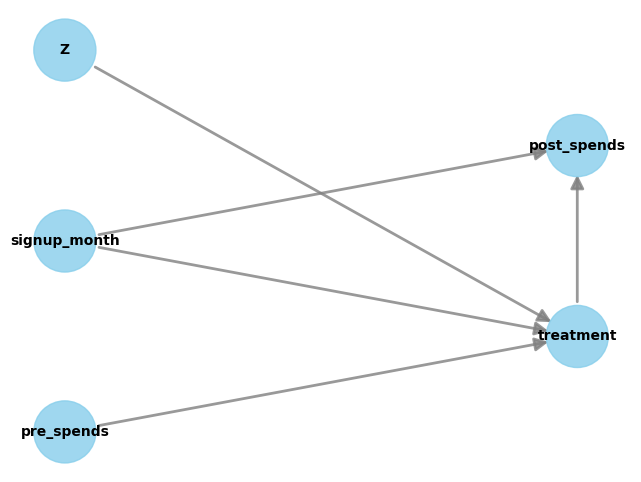

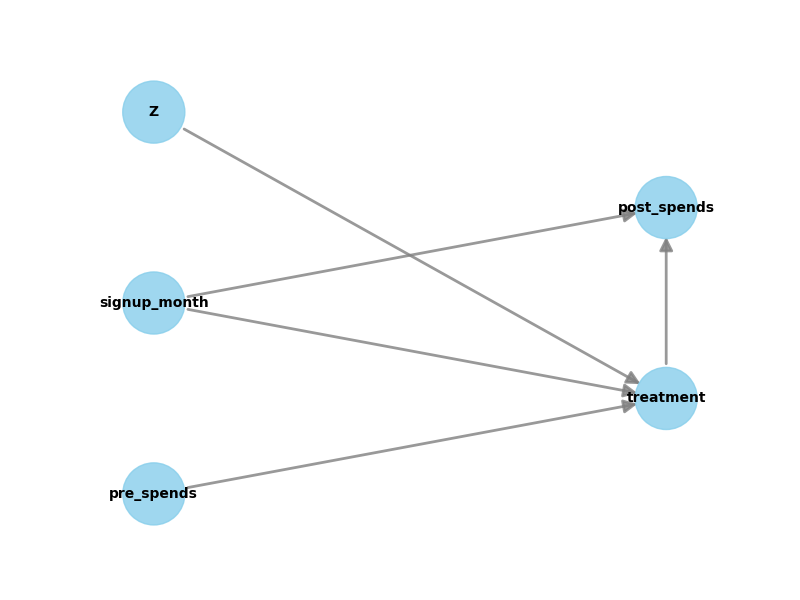

In [ ]:
causal_graph = """digraph {
treatment[label="Program Signup in month i"];
pre_spends;
post_spends;
Z->treatment;
pre_spends -> treatment;
treatment->post_spends;
signup_month->post_spends;
signup_month->treatment;
}"""

# Post-process the data based on the graph and the month of the treatment (signup)
# For each customer, determine their average monthly spend before and after month i
df_i_signupmonth = (
    df[df.signup_month.isin([0, i])]
    .groupby(["user_id", "signup_month", "treatment"])
    .apply(
        lambda x: pd.Series(
            {
                "pre_spends": x.loc[x.month < i, "spend"].mean(),
                "post_spends": x.loc[x.month > i, "spend"].mean(),
            }
        )
    )
    .reset_index()
)
print(df_i_signupmonth)
model = dowhy.CausalModel(data=df_i_signupmonth,
                     graph=causal_graph.replace("\n", " "),
                     treatment="treatment",
                     outcome="post_spends")
model.view_model()
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

In [ ]:
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                   
────────────(E[post_spends|signup_month])
d[treatment]                             
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→post_spends then P(post_spends|treatment,signup_month,U) = P(post_spends|treatment,signup_month)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                                             -1⎤
 ⎢       d                      ⎛       d                     ⎞  ⎥
E⎢────────────────(post_spends)⋅⎜────────────────([treatment])⎟  ⎥
 ⎣d[pre_spends  Z]              ⎝d[pre_spends  Z]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→post_spends then ¬(U →→{pre_spends,Z})
Estimand assumption 2, Exclusion: If we remove {pre_spends,Z}→{treatment}, then ¬({pre_spends,Z}→post_spends)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [ ]:
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.propensity_score_matching",
                                target_units="att")
print(estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                   
────────────(E[post_spends|signup_month])
d[treatment]                             
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→post_spends then P(post_spends|treatment,signup_month,U) = P(post_spends|treatment,signup_month)

## Realized estimand
b: post_spends~treatment+signup_month
Target units: att

## Estimate
Mean value: 111.41986234021633



In [ ]:
refutation = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter",
                     placebo_type="permute", num_simulations=20)
print(refutation)

             Note: The underlying distribution may not be Normal. We assume that it approaches normal with the increase in sample size.


Refute: Use a Placebo Treatment
Estimated effect:111.41986234021633
New effect:-0.25746066863324313
p value:0.48889450461344464



Data Generation:

Multi-Level Treatment Assignment: Instead of a binary treatment, users now can receive one of three treatment levels: 0 (no treatment), 1 (low treatment), or 2 (high treatment). This is achieved by assigning a treatment level randomly to users who signed up after their signup month.

Spending Simulation:

 The spending is adjusted based on the treatment level. The low treatment group receives an increase of 50 in spending, while the high treatment group gets an increase of 100.

Causal Graph Definition:

The causal graph has been updated to reflect the multi-level treatment. The relationships between treatment, signup month, and spending outcomes are depicted.

Data Preparation for Causal Analysis:

The DataFrame is grouped by user ID, signup month, and treatment to compute the average spending before and after the treatment month (i).

Causal Analysis:

The causal model is built using the dowhy library. The treatment and outcome variables are specified.
The effect of treatment is identified and estimated using the linear regression method.

Refutation Test:

A placebo treatment refuter is applied to check the robustness of the estimated treatment effect.

        user_id  signup_month  month  spend  treatment
0             0             4      1    492          0
1             0             4      2    528          0
2             0             4      3    464          0
3             0             4      4    452          2
4             0             4      5    551          2
...         ...           ...    ...    ...        ...
119995     9999            10      8    424          0
119996     9999            10      9    447          0
119997     9999            10     10    416          1
119998     9999            10     11    443          1
119999     9999            10     12    438          1

[120000 rows x 5 columns]


<ipython-input-7-f2631014d08e>:58: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(
ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...


      user_id  signup_month  treatment  pre_spends  post_spends
0           2             0          0       500.0   420.000000
1           5             0          0       467.5   412.000000
2           6             0          0       481.5   409.777778
3           7             0          0       472.0   424.555556
4           8             0          0       498.5   434.111111
...       ...           ...        ...         ...          ...
6418     9989             0          0       493.0   408.000000
6419     9990             0          0       476.0   430.222222
6420     9992             0          0       478.5   420.000000
6421     9995             0          0       482.5   412.111111
6422     9998             0          0       470.5   412.666667

[6423 rows x 5 columns]


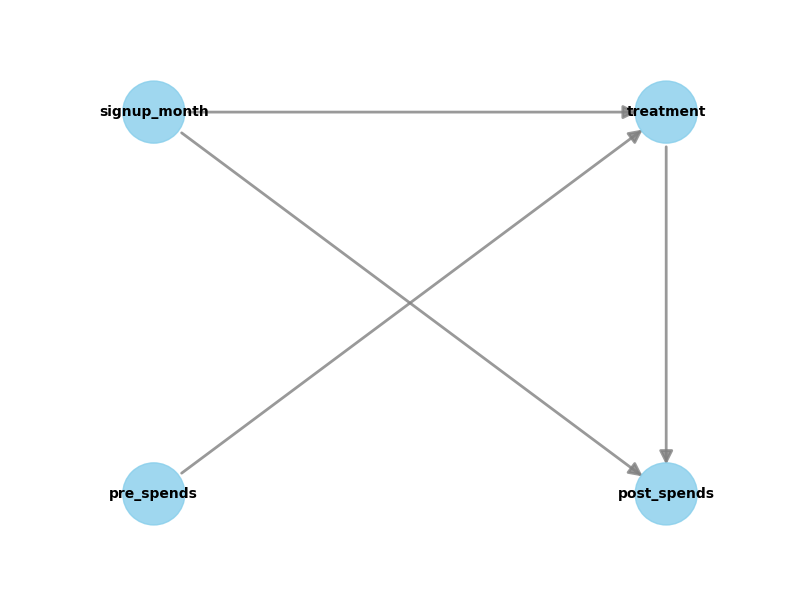

/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFra

IDENTIFIED ESTIMAND
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                   
────────────(E[post_spends|signup_month])
d[treatment]                             
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→post_spends then P(post_spends|treatment,signup_month,U) = P(post_spends|treatment,signup_month)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                                       -1⎤
 ⎢      d                    ⎛      d                   ⎞  ⎥
E⎢─────────────(post_spends)⋅⎜─────────────([treatment])⎟  ⎥
 ⎣d[pre_spends]              ⎝d[pre_spends]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→post_spends then ¬(U →→{pre_spends})
Estimand assumption 2, Exclusion: If we remove {pre_spends}→{treatment}, then ¬({pre_spends}→post_spends)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

Estimand type: EstimandTyp

/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFra

Refutation results:
Refute: Use a Placebo Treatment
Estimated effect:nan
New effect:nan
p value:nan



In [ ]:
# Install the dowhy library if not already installed
!pip install dowhy

# Import necessary libraries
import pandas as pd
import numpy as np

# Set parameters for the simulation
num_users = 10000
num_months = 12

# Generate signup months; a customer could sign up for different treatment levels
signup_months = np.random.choice(np.arange(1, num_months), num_users) * np.random.randint(0, 2, size=num_users)

# Create the initial DataFrame
df = pd.DataFrame({
    'user_id': np.repeat(np.arange(num_users), num_months),
    'signup_month': np.repeat(signup_months, num_months),
    'month': np.tile(np.arange(1, num_months + 1), num_users),
    'spend': np.random.poisson(500, num_users * num_months)  # Base spending
})

# Determine treatment levels: 0 (no treatment), 1 (low treatment), 2 (high treatment)
# Customers who signed up will receive treatment levels based on the month they signed up
df["treatment"] = 0  # Default treatment
df.loc[(df["signup_month"] > 0) & (df["month"] >= df["signup_month"]), "treatment"] = np.random.choice([1, 2], size=(df[(df["signup_month"] > 0) & (df["month"] >= df["signup_month"])].shape[0]))

# Simulating a monthly spending decrease
df["spend"] = df["spend"] - df["month"] * 10

# Simulating treatment effects
df.loc[(df["treatment"] == 1) & (df["signup_month"] < df["month"]), "spend"] += 50  # Low treatment effect
df.loc[(df["treatment"] == 2) & (df["signup_month"] < df["month"]), "spend"] += 100  # High treatment effect

# Display the DataFrame to see the generated data
print(df)

import dowhy

# Set the signup month for analysis
i = 3  # Month to analyze treatment effect

# Define the causal graph
causal_graph = """digraph {
treatment[label="Program Signup (Treatment Levels)"];
pre_spends;
post_spends;
signup_month->treatment;
treatment->post_spends;
pre_spends->treatment;
signup_month->post_spends;
}"""

# Prepare data for causal analysis: Average spending before and after treatment
df_i_signupmonth = (
    df[df.signup_month.isin([0, i])]
    .groupby(["user_id", "signup_month", "treatment"])
    .apply(
        lambda x: pd.Series({
            "pre_spends": x.loc[x.month < i, "spend"].mean(),
            "post_spends": x.loc[x.month > i, "spend"].mean(),
        })
    )
    .reset_index()
)

print(df_i_signupmonth)

# Create a CausalModel object
model = dowhy.CausalModel(data=df_i_signupmonth,
                          graph=causal_graph.replace("\n", " "),
                          treatment="treatment",
                          outcome="post_spends")

# Visualize the causal model
#model.view_model()

# Display the causal model image
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

# Identify the effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print("IDENTIFIED ESTIMAND")
print(identified_estimand)

'''# Estimate the effect using the propensity score matching method
estimate = model.estimate_effect(identified_estimand,
                                  method_name="backdoor.propensity_score_matching",
                                  target_units="att")
print(estimate)

# Perform a refutation test
refutation = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter",
                                     placebo_type="permute", num_simulations=20)
print(refutation)'''

# Estimate the effect using the linear regression method
estimate = model.estimate_effect(identified_estimand,
                                  method_name="backdoor.linear_regression",
                                  target_units="att")
print(identified_estimand)
# Print the estimate
print("Estimate for multi-level treatment:")
print(estimate)

# Perform a refutation test
refutation = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter",
                                     placebo_type="permute", num_simulations=20)
print("Refutation results:")
print(refutation)


Mean Calculation: Adjusted the mean calculation in df_i_signupmonth to avoid NaN values. If there are no records for pre or post spends, it defaults to 0.

        user_id  signup_month  month  spend  treatment
0             0            18      1    523          2
1             0            18      2    470          1
2             0            18      3    461          1
3             0            18      4    456          1
4             0            18      5    458          2
...         ...           ...    ...    ...        ...
119995     9999             0      8    437          0
119996     9999             0      9    398          0
119997     9999             0     10    394          0
119998     9999             0     11    385          0
119999     9999             0     12    392          0

[120000 rows x 5 columns]


<ipython-input-5-055f2dfefe7f>:51: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(
ERROR:dowhy.causal_graph:Error: Pygraphviz cannot be loaded. No module named 'pygraphviz'
Trying pydot ...
/usr/local/lib/python3.10/dist-packages/dowhy/causal_model.py:582: UserWarning: 1 variables are assumed unobserved because they are not in the dataset. Configure the logging level to `logging.WARNING` or higher for additional details.
  warnings.warn(


      user_id  signup_month  treatment  pre_spends  post_spends
0           5             0          0       479.5   414.777778
1           8             0          0       491.0   426.000000
2          11             0          0       449.0   423.333333
3          12             0          0       502.5   422.111111
4          14             0          0       477.5   416.666667
...       ...           ...        ...         ...          ...
3825     9992             0          0       507.0   416.888889
3826     9996             0          0       474.5   420.888889
3827     9998             3          1         0.0   460.500000
3828     9998             3          2       468.5   572.200000
3829     9999             0          0       458.0   421.444444

[3830 rows x 5 columns]


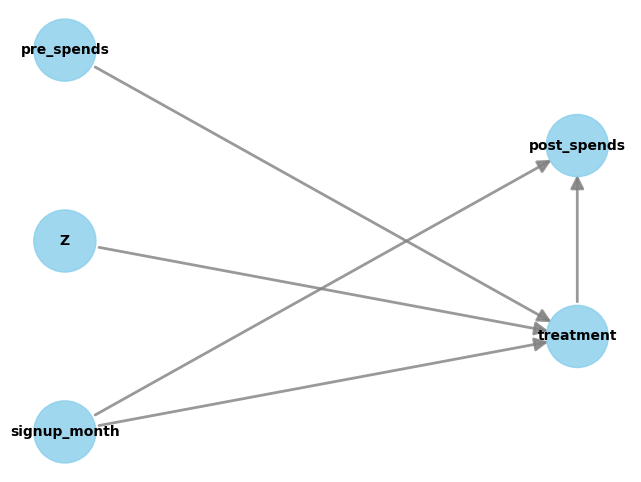

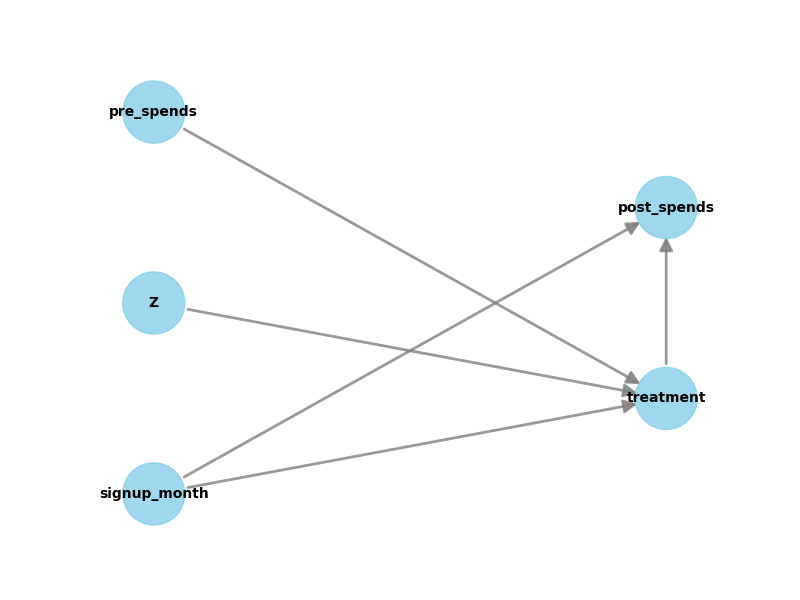

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                                   
────────────(E[post_spends|signup_month])
d[treatment]                             
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→post_spends then P(post_spends|treatment,signup_month,U) = P(post_spends|treatment,signup_month)

### Estimand : 2
Estimand name: iv
Estimand expression:
 ⎡                                                             -1⎤
 ⎢       d                      ⎛       d                     ⎞  ⎥
E⎢────────────────(post_spends)⋅⎜────────────────([treatment])⎟  ⎥
 ⎣d[Z  pre_spends]              ⎝d[Z  pre_spends]             ⎠  ⎦
Estimand assumption 1, As-if-random: If U→→post_spends then ¬(U →→{Z,pre_spends})
Estimand assumption 2, Exclusion: If we remove {Z,pre_spends}→{treatment}, then ¬({Z,pre_spends}→post_spends)

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!

*** Causal Estim

/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:179: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFra

Refute: Use a Placebo Treatment
Estimated effect:100.4002428730688
New effect:0.22809346800599145
p value:0.3462722791973527



In [ ]:
!pip install dowhy

import pandas as pd
import numpy as np

# Creating simulated data
num_users = 10000
num_months = 12

# Simulate signup months with multiple treatments (e.g., 0, 1, 2 for different programs)
signup_months = np.random.choice(np.arange(1, num_months), num_users) * np.random.randint(0, 3, size=num_users)
df = pd.DataFrame({
    'user_id': np.repeat(np.arange(num_users), num_months),
    'signup_month': np.repeat(signup_months, num_months),
    'month': np.tile(np.arange(1, num_months + 1), num_users),
    'spend': np.random.poisson(500, num_users * num_months)
})

# Define treatment levels (0 = no treatment, 1 = low treatment, 2 = high treatment)
df["treatment"] = np.where(df["signup_month"] == 0, 0, np.random.choice([1, 2], size=len(df), p=[0.5, 0.5]))

# Simulating effects
df["spend"] = df["spend"] - df["month"] * 10  # Monthly decreasing effect
after_signup = (df["signup_month"] < df["month"]) & (df["treatment"] > 0)

# Different treatment effects
df.loc[after_signup & (df["treatment"] == 1), "spend"] += 50  # Low treatment effect
df.loc[after_signup & (df["treatment"] == 2), "spend"] += 150  # High treatment effect
print(df)

import dowhy

# Setting the signup month (for ease of analysis)
i = 3

causal_graph = """digraph {
treatment[label="Program Signup (Levels: 0, 1, 2)"];
pre_spends;
post_spends;
Z->treatment;
pre_spends -> treatment;
treatment->post_spends;
signup_month->post_spends;
signup_month->treatment;
}"""

# Post-process the data
df_i_signupmonth = (
    df[df.signup_month.isin([0, i])]
    .groupby(["user_id", "signup_month", "treatment"])
    .apply(
        lambda x: pd.Series(
            {
                "pre_spends": x.loc[x.month < i, "spend"].mean() if x.month[x.month < i].size > 0 else 0,
                "post_spends": x.loc[x.month > i, "spend"].mean() if x.month[x.month > i].size > 0 else 0,
            }
        )
    )
    .reset_index()
)

print(df_i_signupmonth)

model = dowhy.CausalModel(data=df_i_signupmonth,
                     graph=causal_graph.replace("\n", " "),
                     treatment="treatment",
                     outcome="post_spends")
model.view_model()

from IPython.display import Image, display
display(Image(filename="causal_model.png"))

# Identifying the effect
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

# Estimating effect for multi-level treatment
estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.linear_regression",
                                 target_units="att")
print(estimate)

# Refutation
refutation = model.refute_estimate(identified_estimand, estimate, method_name="placebo_treatment_refuter",
                     placebo_type="permute", num_simulations=20)
print(refutation)
